In [1]:
from scipy.integrate import solve_ivp
import numpy as np
import math as m
import matplotlib.pyplot as plt
import PythonFunctions as PF

from astropy.coordinates import get_body
from astropy.coordinates import EarthLocation, AltAz
from astropy.time import Time
import astropy.units as u

In [2]:
# Set your observer location (example: Greenwich Observatory)
observer_location = EarthLocation(lat=51.477*u.deg, lon=0*u.deg, height=0*u.m)
# Get the current UTC time
time_utc = Time.now()
# Get positions at the specified time and observer location
sun_position = get_body('sun',time_utc).transform_to(AltAz(obstime=time_utc, location=observer_location))
jupiter_position = get_body('jupiter', time_utc).transform_to(AltAz(obstime=time_utc, location=observer_location))
moon_position = get_body('moon',time_utc).transform_to(AltAz(obstime=time_utc, location=observer_location))
# Get the distance 
distance_to_sun = sun_position.distance
distance_to_jupiter = jupiter_position.distance
distance_to_moon = moon_position.distance

r_s = distance_to_sun/distance_to_moon
r_j = distance_to_jupiter/distance_to_moon

print('r_s:', r_s)
print('r_j:', r_j)

r_s: 394.9320347122815
r_j: 2024.8180571056805


In [3]:
# These masses represent the Earth-Moon-Sun-Jupiter system
m_1 = 5.974E24  # kg
m_2 = 7.348E22 # kg
m_j = 1.8982E27 # kg
m_s = 1.9891E30 # kg
pi_2 = m_2/(m_1 + m_2)
pi_s = m_s/(m_1 + m_2)
pi_j = m_j/(m_1 + m_2)
print('pi_s:', pi_s)
print('pi_j:', pi_j)
print('Order of magnitude of Sun "Perturbation":', pi_s/(r_s)**2)
print('Order of magnitude of Jupiter Perturbation:', pi_j/(r_j)**2)


pi_s: 328913.8616415432
pi_j: 313.8828073842328
Order of magnitude of Sun "Perturbation": 2.1088099941930967
Order of magnitude of Jupiter Perturbation: 7.655887058363351e-05


In [4]:
# Resonant EM Orbits
# X0 = [0.16686 0, 0, 0, 2.99389, 0]; # 1:1
# X0 = [0.17166 0, 0, 0, 3.00312, 0]; # 1:2
# X0 = [3.34922 0, 0, 0, -3.01527, 0]; # 1:3
# X0 = [0.33752 0, 0, 0, 1.86475, 0]; # 3:4
# X0 =  [0.44416, 0, 0, 0, 1.29134, 0]; # 3:2
# X0 = [0.10252, 0, 0, 0, 3.72303, 0]; # 4:1
# X0 = [1.18945, 0, 0, 0, -0.69908, 0]; # 4:3

# X0 = np.array([1-pi_2,0.0455,0,-0.5,0.5,0.0])
X0 = np.array([0.87, 0.1, 0, 0, -1.48270, 0]) # "SUGGESTED BY RB"

x_0 = X0[0]
y_0 = X0[1]
z_0 = X0[2]
vx_0 = X0[3]
vy_0 = X0[4]
vz_0 = X0[5]

# Then stack everything together into the state vector
r_0 = np.array((x_0, y_0, z_0))
v_0 = np.array((vx_0, vy_0, vz_0))
Y_0 = np.hstack((r_0, v_0))

In [5]:
t_0 = 0  # nondimensional time
t_f = 20  # nondimensional time
t_points = np.linspace(t_0, t_f, 1000*(t_f-t_0))

sol = solve_ivp(PF.nondim_cr3bp, [t_0, t_f], Y_0, args=(pi_2,0,0,r_s,r_j,pi_s,pi_j), atol=1e-9, rtol=1e-6, t_eval=t_points)
Y = sol.y.T
r = Y[:, :3]  # nondimensional distance
v = Y[:, 3:]  # nondimensional velocity
t = sol.t

sol = solve_ivp(PF.nondim_cr3bp_without_pert, [t_0, t_f], Y_0, args=(pi_2,0,0,r_s,r_j,pi_s,pi_j), atol=1e-9, rtol=1e-6, t_eval=t_points)
Y = sol.y.T
r2 = Y[:, :3]  # nondimensional distance
v2 = Y[:, 3:]  # nondimensional velocity

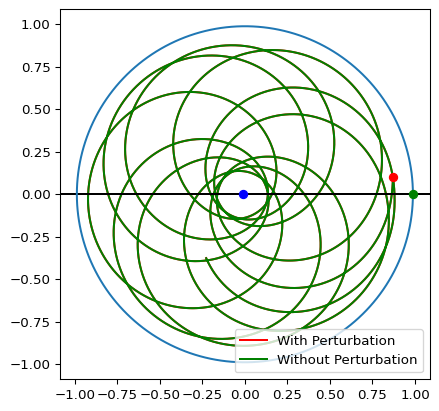

In [6]:
x_2 = (1 - pi_2) * np.cos(np.linspace(0, np.pi, 100))
y_2 = (1 - pi_2) * np.sin(np.linspace(0, np.pi, 100))
fig, ax = plt.subplots(figsize=(5,5), dpi=96)

# Plot the orbits
plt.figure(1)
ax.plot(r[:, 0], r[:, 1], 'r', label="With Perturbation")
ax.plot(r2[:, 0], r2[:, 1], 'g', label="Without Perturbation")
plt.legend(["With Perturbation", "Without Perturbation"])
ax.axhline(0, color='k')
ax.plot(np.hstack((x_2, x_2[::-1])), np.hstack((y_2, -y_2[::-1])))
ax.plot(-pi_2, 0, 'bo', label="$m_1$")
ax.plot(1 - pi_2, 0, 'go', label="$m_2$")
ax.plot(x_0, y_0, 'ro')
ax.set_aspect("equal")
plt.show()

Text(0, 0.5, 'Magnitude of Deviation')

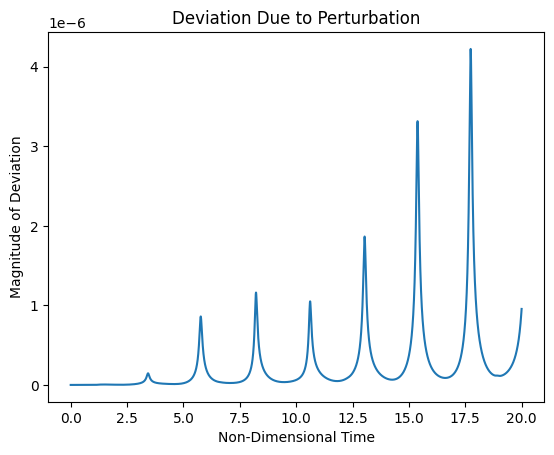

In [7]:
#plt.figure(2)
#ax.plot(t, np.sum((r[:, :3] - r2[:, :3])**2,axis=1)), 'r', label="Deviation")
#np.shape(np.sum((r[:, :3] - r2[:, :3])**2,axis=1))
#np.sum((r[:, :3] - r2[:, :3])**2,axis=1)
plt.plot(t, np.sum((r[:, :3] - r2[:, :3])**2,axis=1))
plt.title("Deviation Due to Perturbation")
plt.xlabel("Non-Dimensional Time")
plt.ylabel("Magnitude of Deviation")